# Quantum linear solver with LCU of Chebyshev polynomials

The code here can be integrated as part of a larger CFD solver, e.g., as in [qc-cfd repository](https://github.com/rolls-royce/qc-cfd/tree/main/1D-Nozzle).
In particular, instead of calling a classical solver, e.g., `x = sparse.linalg.spsolve(mat_raw_scr, b_raw)`, one can call the quantum solver `cheb_lcu_solver(mat_raw_scr, b_raw,...)`.

We implemented two versions for block-encoding, one based on Pauli decomposition of the matrix, and another one based on decomposing the matrix to a finite set of diagonals.

In [1]:
!pip install -qq "classiq[qsp]"
!pip install -qq "classiq[chemistry]"

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
from banded_be import get_banded_diags_be
from cheb_utils import *
from classical_functions_be import get_projected_state_vector, get_svd_range
from pauli_be import get_pauli_be
from scipy import sparse

from classiq import *

np.random.seed(53)

PAULI_TRIM_REL_TOL = 0.1

In [4]:
from classiq.qmod.symbolic import pi


@qfunc
def my_reflect_about_zero(qba: QNum):
    control(qba == 0, lambda: phase(pi))
    phase(pi)


@qfunc
def walk_operator(
    block_enc: QCallable[QArray, QArray], block: QArray, data: QArray
) -> None:
    block_enc(block, data)
    my_reflect_about_zero(block)


@qfunc
def symmetrize_walk_operator(
    block_enc: QCallable[QNum, QArray], block: QNum, data: QArray
):
    my_reflect_about_zero(block)
    within_apply(
        lambda: block_enc(block, data),
        lambda: my_reflect_about_zero(block),
    )


@qfunc
def lcu_cheb(
    powers: CArray[CInt],
    inv_coeffs: CArray[CReal],
    block_enc: QCallable[QNum, QArray],
    mat_block: QNum,
    data: QArray,
    cheb_block: QArray,
) -> None:

    within_apply(
        lambda: inplace_prepare_state(inv_coeffs, 0.0, cheb_block),
        lambda: (
            Z(cheb_block[0]),
            repeat(
                powers.len,
                lambda i: control(
                    cheb_block[i],
                    lambda: power(
                        powers[i],
                        lambda: symmetrize_walk_operator(block_enc, mat_block, data),
                    ),
                ),
            ),
            my_reflect_about_zero(mat_block),
            walk_operator(block_enc, mat_block, data),
        ),
    )

The solvers were developed in the framework of exploring their performance in hybrid CFD schemes. For simplicity, it is assumed that all the properties of the matrices are known explicitly. In particular, we calculate its sigular values for identyfing the range in which we apply the inversion polnomial.

In [4]:
def cheb_lcu_solver(
    mat_raw_scr,
    b_raw,
    log_poly_degree,
    be_method="banded",
    cheb_approx_type="numpy_interpolated",
    preferences=Preferences(),
    constraints=Constraints(),
):

    SCALE = 0.5
    b_norm = np.linalg.norm(b_raw)  # b normalization
    b_normalized = b_raw / b_norm
    data_size = max(1, (len(b_raw) - 1).bit_length())

    # Define block encoding
    if be_method == "pauli":
        data_size, block_size, be_scaling_factor, be_qfunc = get_pauli_be(mat_raw_scr)
    if be_method == "banded":
        data_size, block_size, be_scaling_factor, be_qfunc = get_banded_diags_be(
            mat_raw_scr
        )

    # Get eigenvalues range
    w_min, w_max = get_svd_range(mat_raw_scr / be_scaling_factor)
    # Calculate approximated Chebyshev polynomial
    poly_degree = 2 * (2**log_poly_degree - 1) + 1
    pcoefs, poly_scale = get_cheb_coeff(
        w_min,
        poly_degree,
        w_max,
        scale=SCALE,
        method=cheb_approx_type,
        epsilon=0.01,
    )
    odd_coef = pcoefs[1::2]
    # Calculate prep for Chebyshev LCU
    lcu_size_inv = len(odd_coef).bit_length() - 1
    print(f"Chebyshec LCU size: {lcu_size_inv} qubits.")
    odd_coeffs_signs = np.sign(odd_coef)
    assert np.all(
        odd_coeffs_signs == np.where(np.arange(len(odd_coeffs_signs)) % 2 == 0, 1, -1)
    ), "Non alternating signs for odd coefficients"
    normalization_inv = sum(np.abs(odd_coef))
    print(f"Normalization factor for inversion: {normalization_inv}")
    prepare_probs_inv = (np.abs(odd_coef) / normalization_inv).tolist()

    @qfunc
    def main(
        matrix_block: Output[QNum[block_size]],
        data: Output[QNum[data_size]],
        inv_block: Output[QNum[lcu_size_inv]],
    ):

        allocate(inv_block)
        allocate(matrix_block)
        prepare_amplitudes(b_normalized.tolist(), 0, data)

        lcu_cheb(
            powers=[2**i for i in range(lcu_size_inv)],
            inv_coeffs=prepare_probs_inv,
            block_enc=lambda b, d: invert(lambda: be_qfunc(b, d)),
            mat_block=matrix_block,
            data=data,
            cheb_block=inv_block,
        )

    start_time_syn = time.time()
    qprog = synthesize(main, preferences=preferences, constraints=constraints)

    print("time to syn:", time.time() - start_time_syn)

    execution_preferences = ExecutionPreferences(
        num_shots=1,
        backend_preferences=ClassiqBackendPreferences(
            backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
        ),
    )

    start_time_exe = time.time()
    with ExecutionSession(qprog, execution_preferences) as es:
        es.set_measured_state_filter("matrix_block", lambda state: state == 0.0)
        es.set_measured_state_filter("inv_block", lambda state: state == 0.0)
        results = es.sample()
    print("time to exe:", time.time() - start_time_exe)

    resulting_state = get_projected_state_vector(results, "data")

    normalization_factor = (be_scaling_factor * poly_scale) / b_norm / normalization_inv

    return resulting_state / normalization_factor, qprog

In [5]:
import pathlib

path = (
    pathlib.Path(__file__).parent.resolve()
    if "__file__" in locals()
    else pathlib.Path(".")
)

In [6]:
mat_name = "nozzle_small_scr"
matfile = "matrices/" + mat_name + ".npz"
mat_raw_scr = sparse.load_npz(path / matfile)

b_raw = np.load(path / "matrices/b_nozzle_small.npy")
raw_mat_qubits = len(b_raw).bit_length() - 1  # matrix raw size

print(f"Raw matrix size: {raw_mat_qubits} qubits.")

Raw matrix size: 3 qubits.


In [7]:
# For faster results use the commented out preferences

prefs = Preferences()

# prefs = Preferences(
#     transpilation_option="none", optimization_level=0, debug_mode=False, qasm3=True
# )

log_poly_degree = 5

In [8]:
qsol_banded, qprog_cheb_lcu_banded = cheb_lcu_solver(
    mat_raw_scr,
    b_raw,
    log_poly_degree,
    be_method="banded",
    preferences=prefs,
    constraints=Constraints(optimization_parameter="width"),
)
show(qprog_cheb_lcu_banded)

For error 0.01, and given kappa, the needed polynomial degree is: 591
Performing numpy Chebyshev interpolation, with degree 63
Chebyshec LCU size: 5 qubits.
Normalization factor for inversion: 0.5926349343907911
time to syn: 68.76218581199646
time to exe: 18.693821907043457
Quantum program link: https://platform.classiq.io/circuit/39FLBk0fxtKjv8Uz1tHTbr1Hvxl


In [9]:
qsol_pauli, qprog_cheb_lcu_pauli = cheb_lcu_solver(
    mat_raw_scr,
    b_raw,
    log_poly_degree,
    be_method="pauli",
    preferences=prefs,
    constraints=Constraints(optimization_parameter="width"),
)
show(qprog_cheb_lcu_pauli)

number of Paulis before/after trimming 24/20
For error 0.01, and given kappa, the needed polynomial degree is: 885
Performing numpy Chebyshev interpolation, with degree 63
Chebyshec LCU size: 5 qubits.
Normalization factor for inversion: 0.4151350173670834
time to syn: 120.10498905181885
time to exe: 23.857552766799927
Quantum program link: https://platform.classiq.io/circuit/39FLRAeou4Sy4S25nbmooMIiuEf


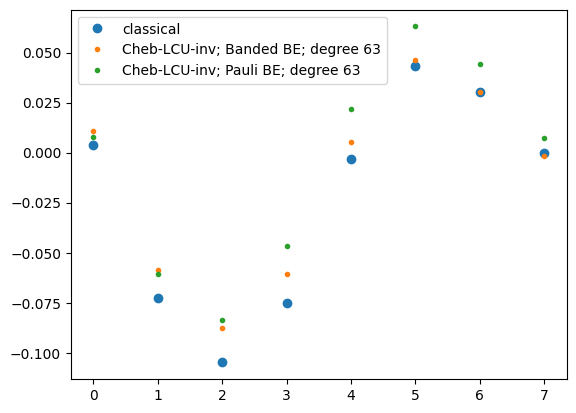

In [10]:
mat_raw = mat_raw_scr.toarray()
expected_sol = np.linalg.solve(mat_raw, b_raw)
plt.plot(expected_sol, "o", label="classical")
ext_idx = np.argmax(np.abs(expected_sol))
correct_sign = np.sign(expected_sol[ext_idx]) / np.sign(qsol_banded[ext_idx])
qsol_banded *= correct_sign
plt.plot(
    qsol_banded,
    ".",
    label=f"Cheb-LCU-inv; Banded BE; degree {2*2**log_poly_degree-1}",
)
correct_sign = np.sign(expected_sol[ext_idx]) / np.sign(qsol_pauli[ext_idx])
qsol_pauli *= correct_sign
plt.plot(
    qsol_pauli,
    ".",
    label=f"Cheb-LCU-inv; Pauli BE; degree {2*2**log_poly_degree-1}",
)
plt.legend()

In [11]:
assert np.linalg.norm(qsol_banded[0 : len(b_raw)] - expected_sol) < 0.25
assert np.linalg.norm(qsol_pauli[0 : len(b_raw)] - expected_sol) < 0.2